Code to replicate the results reported for Study 2.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
from __future__ import division
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms

In [4]:
dat = pd.read_csv("responses.csv")
dat.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
pos_words = [ "superior", "joy", "plentiful", "qualified", "laugh", "clever", "rapid",
              "famous", "useful", "loyal"
            ]
neg_words = [ "inferior", "sorrow", "scarce", "unqualified", "cry", "stupid", "slow",
              "unknown", "useless", "disloyal"
            ]

In [6]:
response_cols = map(str, range(1,11))

# Participants

In [7]:
# Comment to include participants who failed the instructional manipulation check
dat = dat.loc[dat.imc_passed]

In [8]:
ddat = dat.loc[dat.party_affil == "Democrat"]
rdat = dat.loc[dat.party_affil == "Republican"]

In [9]:
len(ddat), len(rdat)

(90, 84)

In [10]:
np.mean(ddat.age), stats.sem(ddat.age), \
np.mean(rdat.age), stats.sem(rdat.age)

(41.43333333333333, 1.464609554988733, 45.23809523809524, 1.4802795327282174)

In [11]:
ddat.gender.value_counts(), rdat.gender.value_counts()

(Female    61
 Male      29
 Name: gender, dtype: int64, Female    59
 Male      25
 Name: gender, dtype: int64)

# Methods and Procedure

In [12]:
dd = ddat.loc[(ddat.Condition == "DEMOCRAT",response_cols)].values
dr = ddat.loc[(ddat.Condition == "REPUBLICAN",response_cols)].values
rd = rdat.loc[(rdat.Condition == "DEMOCRAT",response_cols)].values
rr = rdat.loc[(rdat.Condition == "REPUBLICAN",response_cols)].values

In [13]:
# n in Democratic condition
dd.shape[0], rd.shape[0]

(44, 39)

In [14]:
# n in Republican condition
dr.shape[0], rr.shape[0]

(46, 45)

# Results

In [15]:
for arr in [dd, dr, rd, rr]:
    arr[np.isin(arr, pos_words)] = 1.
    arr[np.isin(arr, neg_words)] = 0.
    arr[~np.isin(arr, (1.,0.))] = np.nan

In [16]:
ppos_dd = np.nanmean(dd, axis=1)
ppos_dr = np.nanmean(dr, axis=1)
ppos_rd = np.nanmean(rd, axis=1)
ppos_rr = np.nanmean(rr, axis=1)
ppos_congruent = np.append(ppos_dd, ppos_rr)
ppos_incongruent = np.append(ppos_dr, ppos_rd)

Calculate difference in the proportion of positive words chosen among participants in a congruent condition (`ppos_congruent`) and participants in an incongruent condition (`ppos_incongruent`).

In [17]:
np.mean(ppos_congruent), stats.sem(ppos_congruent)

(0.7064918851435704, 0.027053786596735057)

In [18]:
np.mean(ppos_incongruent), stats.sem(ppos_incongruent)

(0.4423529411764708, 0.03259876054887346)

In [19]:
dsw_pc = sms.DescrStatsW(ppos_congruent)
dsw_pic = sms.DescrStatsW(ppos_incongruent)
cm = sms.CompareMeans(dsw_pc, dsw_pic)
delta = dsw_pc.mean - dsw_pic.mean
se_delta = cm.std_meandiff_separatevar
print(delta, delta - 2*se_delta, delta + 2*se_delta)

(0.26413894396709964, 0.1794138223432396, 0.34886406559095967)


In [20]:
cm.ttest_ind(usevar="unequal", alternative = "larger")

(6.235197752556866, 1.8233500130148425e-09, 164.8915960130812)

Figure 2a

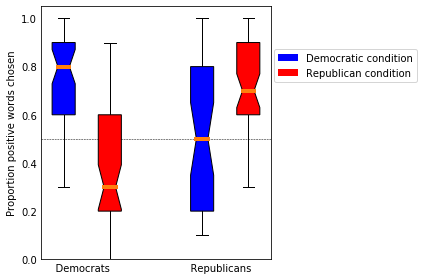

In [21]:
fig, ax = plt.subplots(1)
bplots = ax.boxplot([ ppos_dd, ppos_dr, np.full(2, fill_value=np.nan), ppos_rd,
                      ppos_rr
                    ], notch=True, patch_artist=True, sym="", whis=[5,95]
                   )
bplots["boxes"][0].set_facecolor("blue")
bplots["boxes"][1].set_facecolor("red")
bplots["boxes"][3].set_facecolor("blue")
bplots["boxes"][4].set_facecolor("red")
for med in bplots["medians"]:
    med.set(linewidth=4)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(*xlim)
ax.set_ylim((0,ylim[1]))
ax.plot(xlim, [.5,.5], color = "k", linestyle = "--", linewidth = .5)
legend_elements = [Patch(facecolor="blue", label="Democratic condition"),
                   Patch(facecolor="red", label="Republican condition")
                  ]
ax.legend(handles=legend_elements, loc=(1.01,.7))
ax.set_ylabel("Proportion positive words chosen")
ax.set_xticklabels([ "            Democrats", "", "", "            Republicans", "" ])
ax.tick_params(axis="both", which="both",length=0)
plt.tight_layout()
plt.savefig("figure2a")

Regression model

In [22]:
dat.gender = dat.gender.replace({ "Male": 1, "Female": -1 })

In [23]:
%%R -i dat,pos_words,neg_words
library(lmerTest)
library(tidyverse)

options(contrasts=c("contr.sum","contr.poly"))

df <- dat %>%
    as_tibble() %>%
    select(X1:X10, age, gender, party_affil, party_strength, political_engagement,
           Condition
          ) %>%
    mutate(ID=1:nrow(.)) %>%
    pivot_longer(X1:X10, names_to="item", values_to="pos") %>%
    filter(pos %in% c(pos_words, neg_words)) %>%
    mutate(pos=pos %in% pos_words) %>%
    mutate(party_affil=ifelse(party_affil=="Republican", sqrt(.5), -sqrt(.5)),
           Condition=ifelse(Condition=="REPUBLICAN", sqrt(.5), -sqrt(.5)),
           age=age-18,
           party_strength=party_strength-1,
           political_engagement=political_engagement-1
          )
    
fit <- glmer(pos ~ Condition * party_affil + (1|ID) + (1|item), data=df, family="binomial")
summary(fit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pos ~ Condition * party_affil + (1 | ID) + (1 | item)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2006.0   2038.7   -997.0   1994.0     1733 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9150 -0.6320  0.3143  0.5977  2.6088 

Random effects:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 1.80877  1.3449  
 item   (Intercept) 0.04399  0.2097  
Number of obs: 1739, groups:  ID, 174; item, 10

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.4454     0.1366   3.262  0.00111 ** 
Condition              -0.3021     0.1684  -1.794  0.07277 .  
party_affil             0.1137     0.1683   0.676  0.49928    
Condition:party_affil   1.4539     0.2396   6.067  1.3e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:

In [24]:
%%R
# +- 2 SE
coef.interact <- summary(fit)$coefficients[4,1]
se.interact <- summary(fit)$coefficients[4,2]
print(c(coef.interact - 2*se.interact, coef.interact + 2*se.interact))

[1] 0.9745939 1.9331770


In [25]:
%%R
exp(summary(fit)$coefficients[4,1])

[1] 4.279711


In [26]:
%%R
null.fit <- glmer(pos ~ Condition + party_affil + (1|ID) + (1|item), data=df, family="binomial")
anova_res <- anova(null.fit, fit, test="LRT")
anova_res

Data: df
Models:
null.fit: pos ~ Condition + party_affil + (1 | ID) + (1 | item)
fit: pos ~ Condition * party_affil + (1 | ID) + (1 | item)
         npar    AIC    BIC   logLik deviance  Chisq Df Pr(>Chisq)    
null.fit    5 2038.2 2065.5 -1014.11   2028.2                         
fit         6 2006.0 2038.7  -996.98   1994.0 34.269  1    4.8e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [27]:
%%R
fit <- glmer(pos ~ Condition * party_affil + Condition * age + Condition * gender + Condition * party_affil * party_strength + Condition * party_affil * political_engagement + (1|ID) + (1|item),
             data = df, family="binomial", glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000))
            )
summary(fit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: pos ~ Condition * party_affil + Condition * age + Condition *  
    gender + Condition * party_affil * party_strength + Condition *  
    party_affil * political_engagement + (1 | ID) + (1 | item)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
  2000.3   2098.6   -982.1   1964.3     1721 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3814 -0.6361  0.3203  0.6004  2.8858 

Random effects:
 Groups Name        Variance Std.Dev.
 ID     (Intercept) 1.44344  1.2014  
 item   (Intercept) 0.04377  0.2092  
Number of obs: 1739, groups:  ID, 174; item, 10

Fixed effects:
                                            Estimate Std. Error z value
(Intercept)                                 0.363261   0.385278   0.943
Condition                                  -0.757

Generates the dataframe used to create Figure 2b, which can be recreated by running the script fig2b.py.

In [28]:
dddat = dat.loc[(dat.party_affil=="Democrat") & (dat.Condition=="DEMOCRAT")]
drdat = dat.loc[(dat.party_affil=="Democrat") & (dat.Condition=="REPUBLICAN")]
rddat = dat.loc[(dat.party_affil=="Republican") & (dat.Condition=="DEMOCRAT")]
rrdat = dat.loc[(dat.party_affil=="Republican") & (dat.Condition=="REPUBLICAN")]
avbCongruent = ppos_congruent
avbIncongruent = 1-ppos_incongruent
spiCongruent = np.append(dddat.party_strength, rrdat.party_strength)
spiIncongruent = np.append(drdat.party_strength, rddat.party_strength)
dpeCongruent = np.append(dddat.political_engagement, rrdat.political_engagement)
dpeIncongruent = np.append(drdat.political_engagement, rddat.political_engagement)
figdatCongruent = pd.DataFrame(np.concatenate((avbCongruent[:,None], 
                                               spiCongruent[:,None],
                                               dpeCongruent[:,None]), axis=1),
                               columns=["avb","spi","dpe"]
                              )
figdatIncongruent = pd.DataFrame(np.concatenate((avbIncongruent[:,None],
                                                 spiIncongruent[:,None],
                                                 dpeIncongruent[:,None]), axis=1),
                                 columns=["avb","spi","dpe"]
                                )
figdat = pd.concat((figdatCongruent,figdatIncongruent))
figdat.to_csv("fig2b.csv")

In [29]:
avb = figdat.avb.values
navb = len(avb[avb > .5])
n = len(avb)
p = navb / n
se = np.sqrt(p*(1-p)/n)
print(p, p-2*se, p+2*se)

(0.6781609195402298, 0.6073270217604239, 0.7489948173200358)


In [30]:
navb, n

(118, 174)